In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import joblib
import sklearn


In [2]:
MODEL_DIR = "models"

os.makedirs(MODEL_DIR, exist_ok=True)


In [3]:
try:
    import xgboost as xgb
    XGB_AVAILABLE = True
except Exception:
    XGB_AVAILABLE = False
    print("xgboost not available — will skip XGBoost steps (install xgboost if you want it).")


In [4]:
df=pd.read_csv(r"C:\Users\AL-AZHARY\OneDrive\Desktop\ROP dataset\drilling log ds\ROP data .csv")
df.info(); df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151 entries, 0 to 150
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Depth     151 non-null    float64
 1   WOB       151 non-null    float64
 2   SURF_RPM  151 non-null    float64
 3   ROP_AVG   151 non-null    float64
 4   PHIF      151 non-null    float64
 5   VSH       151 non-null    float64
 6   SW        151 non-null    float64
 7   KLOGH     151 non-null    float64
dtypes: float64(8)
memory usage: 9.6 KB


,Depth,WOB,SURF_RPM,ROP_AVG,PHIF,VSH,SW,KLOGH
0,3305.0,26217.864,1.314720,0.004088,0.086711,0.071719,1.0,0.001
1,3310.0,83492.293,1.328674,0.005159,0.095208,0.116548,1.0,0.001
2,3315.0,97087.882,1.420116,0.005971,0.061636,0.104283,1.0,0.001
3,3320.0,54793.206,1.593931,0.005419,0.043498,0.110040,1.0,0.001
4,3325.0,50301.579,1.653262,0.005435,0.035252,0.120808,1.0,0.001


In [5]:
df.describe()

,Depth,WOB,SURF_RPM,ROP_AVG,PHIF,VSH,SW,KLOGH
count,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000
mean,3697.417219,45393.934391,2.034981,0.007800,0.084423,0.299809,0.975579,37.072228
std,227.169433,15784.246882,0.208492,0.001476,0.068230,0.264596,0.108946,127.186210
min,3305.000000,16961.916000,1.314720,0.002666,0.002968,0.049451,0.351393,-0.001124
25%,3502.500000,34320.946500,1.998711,0.007368,0.037550,0.108539,1.000000,0.001000
50%,3700.000000,44243.480000,1.999697,0.008157,0.059274,0.193100,1.000000,0.001000
75%,3887.500000,53212.685000,2.001069,0.008760,0.097212,0.387664,1.000000,0.001000
max,4085.000000,97087.882000,2.639233,0.010447,0.279346,1.000000,1.013335,709.158935


In [6]:
# 4) Outlier handling (IQR winsorization) for selected numeric features
# -------------------------
def winsorize_series(s, lower_q=0.01, upper_q=0.99):
    low = s.quantile(lower_q)
    high = s.quantile(upper_q)
    return s.clip(lower=low, upper=high)

num_to_wins = df.drop(columns=["ROP_AVG"])
for c in num_to_wins:
    df[c] = winsorize_series(df[c])

In [7]:
df.describe()

,Depth,WOB,SURF_RPM,ROP_AVG,PHIF,VSH,SW,KLOGH
count,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000
mean,3697.417219,45327.752146,2.035617,0.007800,0.084349,0.299839,0.975863,36.756046
std,226.942984,15571.422839,0.205981,0.001476,0.067939,0.264568,0.107114,125.552828
min,3312.500000,17383.138000,1.374395,0.002666,0.005719,0.051826,0.378137,0.001000
25%,3502.500000,34320.946500,1.998711,0.007368,0.037550,0.108539,1.000000,0.001000
50%,3700.000000,44243.480000,1.999697,0.008157,0.059274,0.193100,1.000000,0.001000
75%,3887.500000,53212.685000,2.001069,0.008760,0.097212,0.387664,1.000000,0.001000
max,4077.500000,88424.574000,2.634557,0.010447,0.267626,1.000000,1.008439,663.525169


In [8]:
df.columns

Index(['Depth', 'WOB', 'SURF_RPM', 'ROP_AVG', 'PHIF', 'VSH', 'SW', 'KLOGH'], dtype='object')

In [9]:
# Drop obviously useless constant columns (e.g., SW if nearly constant)
if "SW" in df.columns:
    if df["SW"].nunique() <= 2 or df["SW"].std() < 1e-3:
        print("Dropping SW (constant or near-constant).")
        df = df.drop(columns=["SW"])

In [10]:
#Specific Energy (SE)
df["SE"] = (df["WOB"] / df["PHIF"]) + (df["SURF_RPM"] * df["KLOGH"])

#Mechanical Specific Energy (MSE) — simplified
df["MSE"] = df["WOB"] + (120 * df["SURF_RPM"])

#Drilling Efficiency
df["EFF"] = df["ROP_AVG"] / df["WOB"]


# 4) HHP estimate (if no pressure/flow in dataset we approximate)
df["HHP_est"] = (df["KLOGH"] * df["SURF_RPM"]) / (df["KLOGH"].median() + 1e-6)  # normalized proxy

# 5) Log transform of permeability to reduce outliers
df["KLOGH_log"] = np.log1p(df["KLOGH"].clip(lower=0))


# 6) Interaction terms
df["WOBxRPM"] = df["WOB"] * df["SURF_RPM"]
df["WOB_div_RPM"] = df["WOB"] / (df["SURF_RPM"].replace(0, np.nan).fillna(df["SURF_RPM"].median()))


# 7) Rate-of-change (first diff) features
for c in ["WOB","SURF_RPM","Depth"]:
    if c in df.columns:
        df[c + "_d1"] = df[c].diff().fillna(0)

# Normalize ROP (target normalization) as extra signal (we'll not use as input to avoid leakage)
df["ROP_z"] = (df["ROP_AVG"] - df["ROP_AVG"].mean()) / (df["ROP_AVG"].std() + 1e-9)


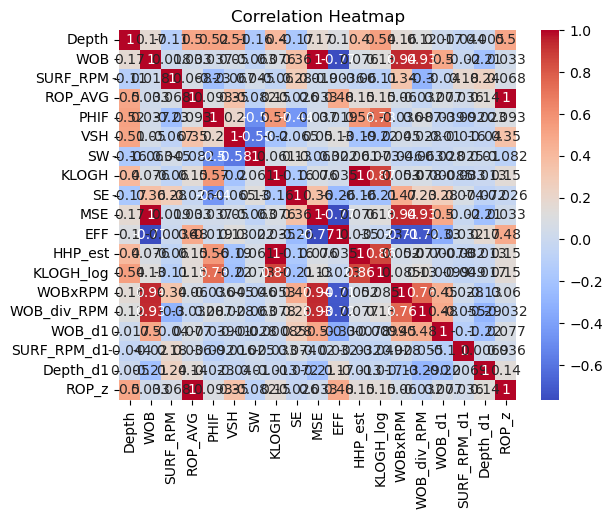

In [11]:
# Correlation Heatmap
plt.figure()
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


In [12]:
x=df.drop(['ROP_AVG','ROP_z'],axis=1)

In [13]:
y =df["ROP_AVG"]

In [14]:
from sklearn.model_selection import train_test_split, KFold, GroupKFold, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler,StandardScaler, FunctionTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor

In [15]:
x_train,x_test,y_train,y_test=train_test_split(x, y, test_size=0.2, random_state=42)

In [16]:
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

Log transformation of the target variable was applied to reduce skewness and stabilize variance, leading to improved model generalization.

In [17]:
# Rolling windows (moving averages / std) using depth-order or index-order
window = 3
for col in ["WOB","SURF_RPM","PHIF","KLOGH_log"]:
    x_train[f"{col}_MA{window}"] = x_train[col].rolling(window=window, min_periods=1).mean().fillna(method='bfill').fillna(method='ffill')
    x_test[f"{col}_MA{window}"] = x_test[col].rolling(window=window, min_periods=1).mean().fillna(method='bfill').fillna(method='ffill')

    #df[f"{col}_STD{window}"] = df[col].rolling(window=window, min_periods=1).std().fillna(0)



In [18]:
# Scaling
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

robscaler=RobustScaler()
x_train_Robscaled = robscaler.fit_transform(x_train)
x_test_Robscaled = robscaler.transform(x_test)

from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False)
x_train_poly = poly.fit_transform(x_train_scaled)
x_test_poly = poly.transform(x_test_scaled)


In [54]:
original_features=x_train.columns.tolist()
feature_names=poly.get_feature_names_out(original_features)

In [55]:
x_train_poly_df = pd.DataFrame(x_train_poly, columns=feature_names)
x_train_poly_df.head()

,Depth,WOB,SURF_RPM,PHIF,VSH,SW,KLOGH,SE,MSE,EFF,...,WOB_MA3^2,WOB_MA3 SURF_RPM_MA3,WOB_MA3 PHIF_MA3,WOB_MA3 KLOGH_log_MA3,SURF_RPM_MA3^2,SURF_RPM_MA3 PHIF_MA3,SURF_RPM_MA3 KLOGH_log_MA3,PHIF_MA3^2,PHIF_MA3 KLOGH_log_MA3,KLOGH_log_MA3^2
0,-1.414035,-0.994261,2.495791,-0.835524,-0.838384,0.254727,-0.272640,0.088270,-0.990079,0.683411,...,3.019458,-6.844286,2.756750,1.177991,15.514125,-6.248798,-2.670183,2.516898,1.075500,0.459573
1,1.156937,-0.788454,-1.663383,1.978343,-0.233036,-0.015113,-0.029175,-0.797629,-0.791318,-1.439540,...,2.424489,-0.989406,-1.776101,-1.796817,0.403765,0.724806,0.733260,1.301113,1.316289,1.331642
2,-1.502689,-0.014399,2.694802,-0.440135,-0.807402,0.254727,-0.272640,-0.185151,-0.009828,-0.523727,...,1.090138,-1.923147,-0.508565,-0.567299,3.392683,0.897175,1.000789,0.237253,0.264653,0.295217
3,1.201265,-0.978332,-0.148170,2.113926,-0.492133,0.235666,1.008752,-0.813969,-0.978635,0.929279,...,1.070768,-0.457339,-2.475999,-2.431267,0.195336,1.057532,1.038427,5.725396,5.621959,5.520391
4,-0.527493,-0.597072,-0.143503,-0.492806,-0.402386,0.258048,-0.272640,-0.287139,-0.597347,0.677156,...,0.851614,-1.150521,-0.734687,-1.041223,1.554340,0.992554,1.406680,0.633815,0.898263,1.273047


In [56]:
x_test_poly_df = pd.DataFrame(x_test_poly, columns=feature_names)

In [23]:
def eval_preds(y_true, y_pred):
    return {
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),   
        "MAE": mean_absolute_error(y_true, y_pred),
        "R2": r2_score(y_true, y_pred)
    }

In [57]:
# ---------------- Baseline models ----------------
print("\nTraining baseline models...")
models = {}
models["Linear"] = LinearRegression().fit(x_train_scaled, y_train_log)
models["Ridge"] = Ridge(random_state=42).fit(x_train_Robscaled, y_train_log)
models["Lasso"] = Lasso(random_state=42).fit(x_train_Robscaled, y_train_log)
models["RandomForest"] = RandomForestRegressor(n_estimators=300, random_state=42).fit(x_train_poly_df, y_train_log)
if XGB_AVAILABLE:
    models["XGBoost"] = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=200,
        random_state=42
    ).fit(x_train_poly_df, y_train_log)




Training baseline models...


In [58]:
# Quick baseline evaluation (no HPO)
baseline_results = {}

for name, model in models.items():
    if name in ["Linear"]:
        y_pred_log = model.predict(x_test_scaled)
        y_pred = np.expm1(y_pred_log) 
    elif name in ["Ridge","Lasso"]:
        y_pred_log = model.predict(x_test_Robscaled)
        y_pred = np.expm1(y_pred_log) 

    else:
        y_pred_log = model.predict(x_test_poly_df)
        y_pred = np.expm1(y_pred_log) 
    baseline_results[name + "_base"] = eval_preds(y_test_log, y_pred)
    metrics=baseline_results[name + "_base"] 
    print(f"{name} baseline -> RMSE: {metrics['RMSE']:.6g}, R2: {metrics['R2']:.4f}")


Linear baseline -> RMSE: 0.000906429, R2: 0.5477
Ridge baseline -> RMSE: 0.000989629, R2: 0.4608
Lasso baseline -> RMSE: 0.00133437, R2: 0.0197
RandomForest baseline -> RMSE: 0.000883522, R2: 0.5702
XGBoost baseline -> RMSE: 0.000870806, R2: 0.5825


In [59]:
# ---------------- HPO for RandomForest ----------------
from scipy.stats import randint as sp_randint, uniform as sp_uniform

print("\nStarting RandomForest HPO (RandomizedSearchCV)...")
rf_param_dist = {
    "n_estimators": sp_randint(100, 600),
    "max_depth": sp_randint(3, 20),
    "min_samples_split": sp_randint(2, 10),
    "min_samples_leaf": sp_randint(1, 6),
    "max_features": ["auto", "sqrt", "log2", 0.5, 0.8]
}
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
cv = KFold(n_splits=4, shuffle=True, random_state=42)
rf_search = RandomizedSearchCV(rf, rf_param_dist, n_iter=30, cv=cv, scoring='neg_root_mean_squared_error', random_state=42, n_jobs=-1, verbose=1)
rf_search.fit(x_train_poly_df, y_train_log)
best_rf = rf_search.best_estimator_
print("RF best params:", rf_search.best_params_)

# Evaluate tuned RF
preds_rf = best_rf.predict(x_test_poly_df)
baseline_results["RandomForest_tuned"] = eval_preds(y_test_log, preds_rf)
print("RandomForest_tuned:", baseline_results["RandomForest_tuned"])

# ---------------- HPO for XGBoost if available ----------------
if XGB_AVAILABLE:
    print("\nStarting XGBoost HPO...")
    xgb_param_dist = {
        "n_estimators": sp_randint(50, 500),
        "max_depth": sp_randint(2, 12),
        "learning_rate": sp_uniform(0.01, 0.3),
        "subsample": sp_uniform(0.5, 0.5),
        "colsample_bytree": sp_uniform(0.5, 0.5)
    }
    xgbr = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)
    xgb_search = RandomizedSearchCV(xgbr, xgb_param_dist, n_iter=30, cv=cv, scoring='neg_root_mean_squared_error', random_state=42, n_jobs=-1, verbose=1)
    xgb_search.fit(x_train_poly_df, y_train_log)
    best_xgb = xgb_search.best_estimator_
    preds_xgb = best_xgb.predict(x_test_poly_df)
    baseline_results["XGBoost_tuned"] = eval_preds(y_test_log, preds_xgb)
    print("XGBoost_tuned:", baseline_results["XGBoost_tuned"])

# ---------------- Comparison table ----------------
comp = []
for k, v in baseline_results.items():
    comp.append([k, v["RMSE"], v["MAE"], v["R2"]])
comp_df = pd.DataFrame(comp, columns=["Model", "RMSE", "MAE", "R2"]).sort_values("RMSE")
print("\nComparison table:\n", comp_df)

comp_df.to_csv(os.path.join(MODEL_DIR, "comparison_table_after_fixes.csv"), index=False)

# ---------------- Save final artifacts ----------------
joblib.dump(best_rf, os.path.join(MODEL_DIR, "best_rf.joblib"))
joblib.dump(robscaler, os.path.join(MODEL_DIR, "robscaler.joblib"))
pd.Series(x.columns).to_csv(os.path.join(MODEL_DIR, "feature_list.csv"), index=False)
print("\nSaved best_rf, scaler and feature list in", MODEL_DIR)




Starting RandomForest HPO (RandomizedSearchCV)...
Fitting 4 folds for each of 30 candidates, totalling 120 fits
RF best params: {'max_depth': 11, 'max_features': 0.5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 147}
RandomForest_tuned: {'RMSE': 0.0009021879228294439, 'MAE': 0.0006045290399400243, 'R2': 0.5518843583497006}

Starting XGBoost HPO...
Fitting 4 folds for each of 30 candidates, totalling 120 fits
XGBoost_tuned: {'RMSE': 0.000892331777822744, 'MAE': 0.0005988502828253718, 'R2': 0.5616219464513752}

Comparison table:
                 Model      RMSE       MAE        R2
4        XGBoost_base  0.000871  0.000603  0.582517
3   RandomForest_base  0.000884  0.000582  0.570236
6       XGBoost_tuned  0.000892  0.000599  0.561622
5  RandomForest_tuned  0.000902  0.000605  0.551884
0         Linear_base  0.000906  0.000811  0.547662
1          Ridge_base  0.000990  0.000705  0.460811
2          Lasso_base  0.001334  0.000996  0.019719

Saved best_rf, scaler and feat

In [60]:
baseline_results

{'Linear_base': {'RMSE': 0.0009064285762138768,
  'MAE': 0.0008114693819000022,
  'R2': 0.5476618030121219},
 'Ridge_base': {'RMSE': 0.0009896289062499759,
  'MAE': 0.000704902710235302,
  'R2': 0.4608112408515299},
 'Lasso_base': {'RMSE': 0.0013343728117527949,
  'MAE': 0.000995788069325924,
  'R2': 0.01971929555754559},
 'RandomForest_base': {'RMSE': 0.0008835216167778536,
  'MAE': 0.0005821435592957066,
  'R2': 0.5702355929032386},
 'XGBoost_base': {'RMSE': 0.0008708061185631636,
  'MAE': 0.000602619013628193,
  'R2': 0.5825167757092904},
 'RandomForest_tuned': {'RMSE': 0.0009021879228294439,
  'MAE': 0.0006045290399400243,
  'R2': 0.5518843583497006},
 'XGBoost_tuned': {'RMSE': 0.000892331777822744,
  'MAE': 0.0005988502828253718,
  'R2': 0.5616219464513752}}

In [61]:
best_model_name = min(
    baseline_results,
    key=lambda x: baseline_results[x]["RMSE"]
)
print("Best model:", best_model_name)

Best model: XGBoost_base


In [62]:
print(XGB_AVAILABLE)
print(models.keys())

True
dict_keys(['Linear', 'Ridge', 'Lasso', 'RandomForest', 'XGBoost'])


In [63]:
final_model = models["XGBoost"]  # Selected after CV + tuning

In [64]:
joblib.dump(final_model, "final_rop_model.pkl")
joblib.dump(poly, "scaler+poly.pkl")
joblib.dump(list(x.columns), "features.pkl")

['features.pkl']

# SHAP Feature Importance (Model Explainability)


In [65]:
import shap

explainer = shap.Explainer(
    model=final_model.predict,
    masker=x_train_poly_df,
    algorithm="permutation"
)


In [66]:
shap_values = explainer(x_test_poly_df,max_evals=600)


PermutationExplainer explainer: 32it [00:11,  2.88s/it]                                                                


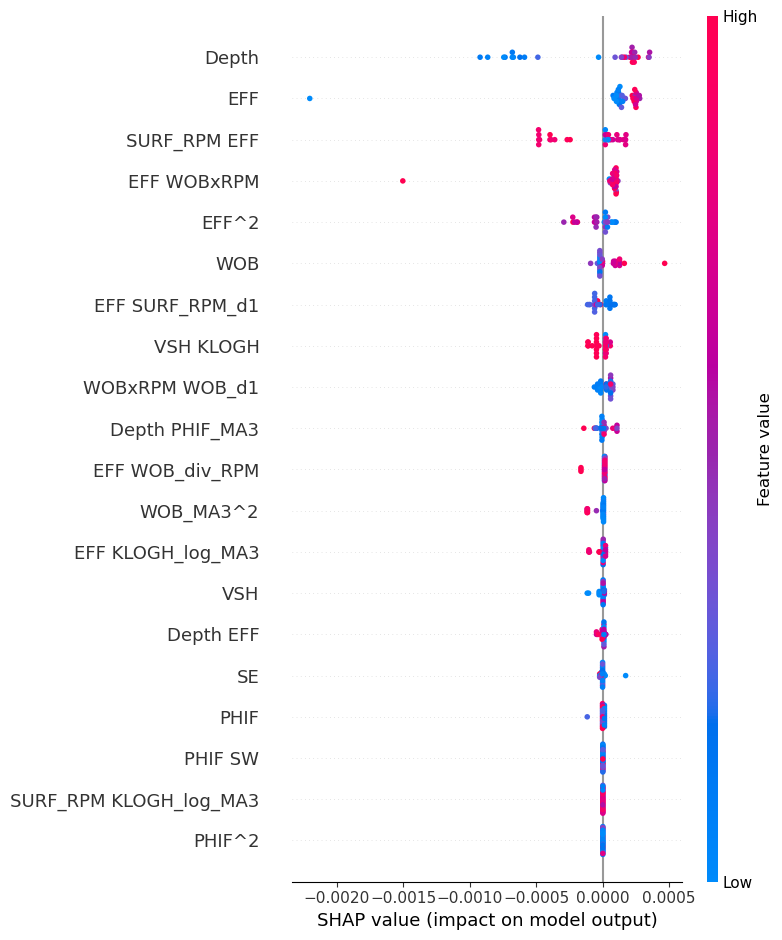

In [67]:
# Global importance
shap.summary_plot(shap_values, x_test_poly_df)

Polynomial feature names were generated using the original training feature set prior to scaling to maintain full consistency between preprocessing and model explainability.

The SHAP summary plot shows that the model prediction of ROP is mainly driven by a small subset of primary features and their interaction terms. High values of key operational parameters contribute positively to ROP, while low values reduce drilling performance. The presence of interaction and squared terms highlights the non-linear behavior of drilling dynamics.

Although polynomial expansion increased feature dimensionality, SHAP analysis confirmed that only a limited number of interaction terms have a significant impact on model predictions.

Local explanation

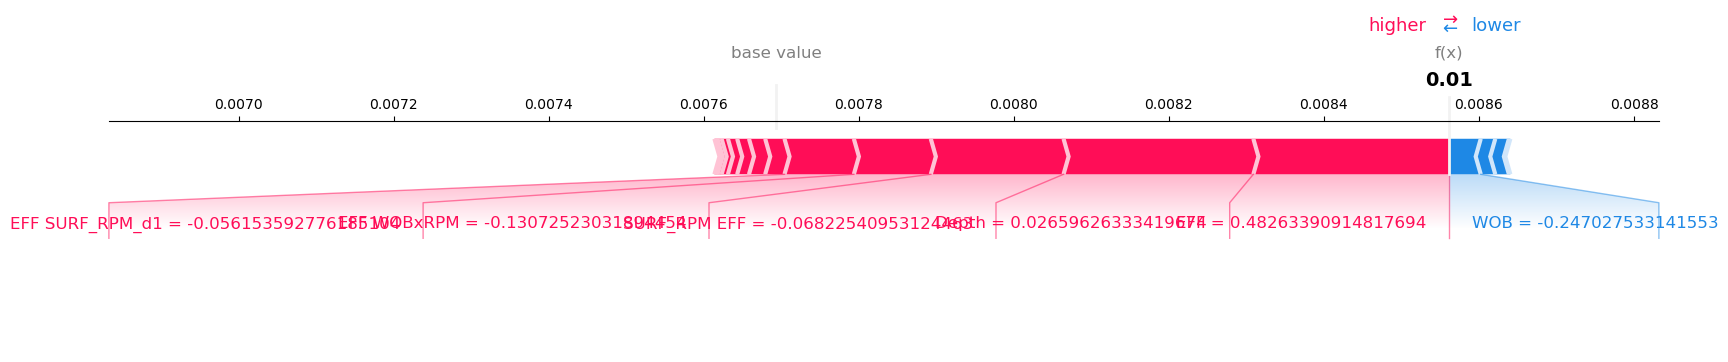

In [69]:
shap.force_plot(
    shap_values.base_values[0],
    shap_values.values[0],
    x_test_poly_df.iloc[0],
    matplotlib=True
)

SHAP values were used to interpret the model and identify the most influential drilling parameters affecting ROP predictions.

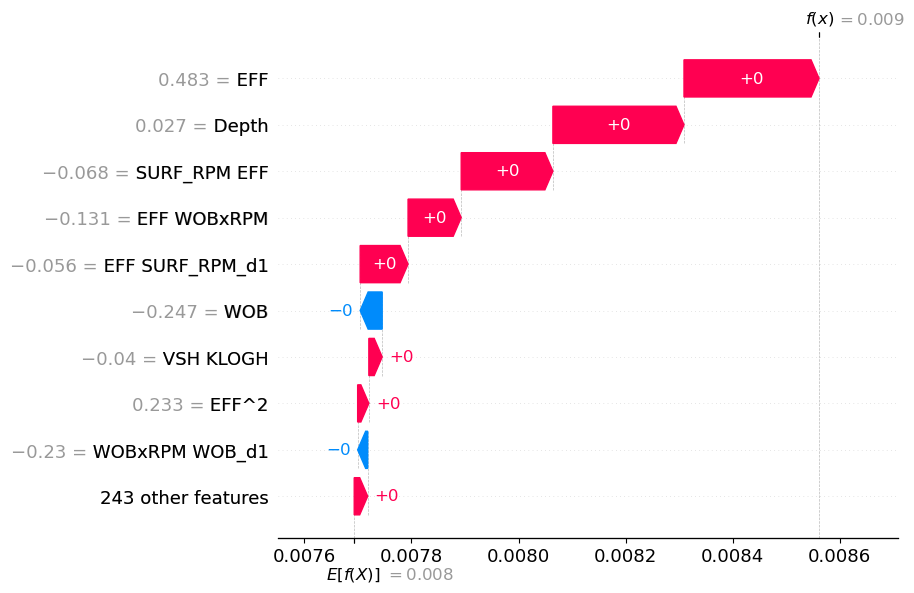

In [70]:
shap.plots.waterfall(shap_values[0], max_display=10)


This SHAP decision plot explains how the model moves from the baseline prediction 
𝐸
[
𝑓
(
𝑥
)
]
=
0.008
 to the final prediction 
𝑓
(
𝑥
)
=
0.009
 for a single sample. Positive SHAP values (red arrows) push the prediction to the right (higher), while negative SHAP values (blue arrows) push it to the left (lower).

In this example, features like EFF 
(
+
0.483
)
, EFF² 
(
+
0.233
)
, and Depth 
(
+
0.027
)
 increase the prediction, whereas WOB 
(
−
0.247
)
, WOBxRPM WOB_d1 
(
−
0.23
)
, and several interaction terms (e.g. EFF WOBxRPM, SURF_RPM EFF) decrease it. The remaining 243 features have a relatively small net effect. Overall, the large positive and negative contributions almost cancel out, so the final prediction is only slightly higher than the baseline.

# Error Analysis (Model Diagnostics)

Predicted vs Actual

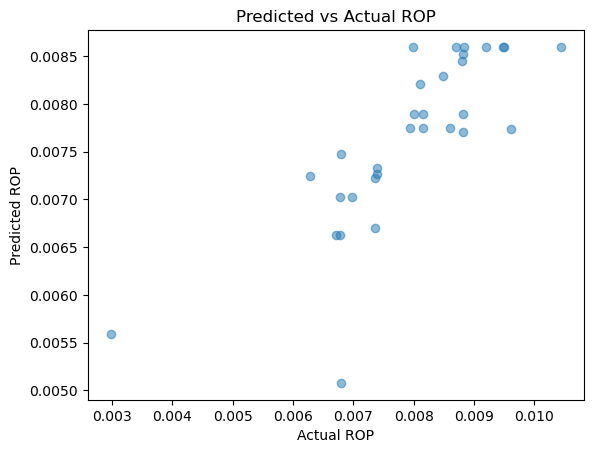

In [71]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual ROP")
plt.ylabel("Predicted ROP")
plt.title("Predicted vs Actual ROP")
plt.show()

This scatter plot compares the predicted Rate of Penetration (ROP) values against the actual ROP values. Each point represents a single data sample. The closer the points are to the diagonal line (where predicted equals actual), the better the model performance. In this plot, most points cluster around the diagonal, indicating a strong positive correlation and reasonably accurate predictions. Some deviation exists, but overall, the model seems to capture the ROP trend well.

Residuals vs Depth

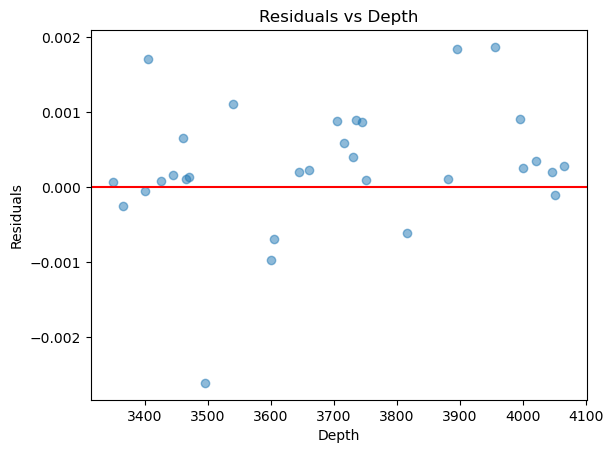

In [72]:
residuals = y_test - y_pred

plt.scatter(x_test["Depth"], residuals, alpha=0.5)
plt.axhline(0, color="red")
plt.xlabel("Depth")
plt.ylabel("Residuals")
plt.title("Residuals vs Depth")
plt.show()

Residual analysis was conducted to assess model bias and variance across depth intervals.

This scatter plot shows residuals versus depth, helping assess the regression model's fit. Each blue dot represents the prediction error (actual minus predicted) at a specific depth. The red horizontal line at 
y
=
0
 indicates perfect prediction. The residuals appear randomly scattered around this line, suggesting the model has no obvious bias across depth and performs reasonably well. The residuals are small, indicating good prediction accuracy.

In [ ]:
models/
│── final_rop_model.pkl
│── scaler.pkl
│── features.pkl
│── best_rf.joblib
│── comparison_table.csv

## Auther
   # Aya Elsadek 